In [1]:
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 

from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm




from imageio import imread
from glob import glob
import h5py
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


import pandas as pd

from sklearn.metrics import accuracy_score, jaccard_score

import time
sam_model = sam_model_registry['vit_h'](checkpoint= "sam_model_best.pth").to('cuda')

In [4]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [3]:
class knee(Dataset):
    def __init__(self, paths,processor =None, transform=None, target_transform=None):
        self.img_dir = paths
        self.transform = transform
        self.target_transform = target_transform
        self.processor = processor

    def __len__(self):
        length = len(glob(self.img_dir[0] + "/*"))
        return length
    

    def __getitem__(self, idx):
        #There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
        fname_img = sorted(glob(self.img_dir[0] + "/*"))[idx]        
        #but there are multiple mask images in each mask path
        fname_seg = sorted(glob(self.img_dir[1] + "/*"))[idx]             
        #the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
        # img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        # img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        with h5py.File(fname_img,'r') as hf:
            img = np.uint8(hf['data'])
        # img = img/255.0
        img = np.moveaxis(img, -1, 0)
        
#         if self.transform:
#             img = torch.FloatTensor(img)
#             state = torch.get_rng_state()
#             img = self.transform(img)
#             torch.set_rng_state(state)

#             # img =img
#         else:    
#             img = torch.FloatTensor(img)
       
        #Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background/ a  _different_ nuclei
        # masks  = imread(mask_imgs)/255.0
        with h5py.File(fname_seg,'r') as hf:
            seg = np.uint8(hf['data'])
    
        if self.target_transform:
            masks = torch.FloatTensor(seg)
            
            masks = masks.unsqueeze(0)
            masks = self.target_transform(seg)
           
        else:
            seg = seg[...,0]
            seg = np.moveaxis(seg, -1, 0)
            masks = torch.Tensor(seg).long()
            # seg[:,1] = seg[:,1] * 2 
            # seg[:,0] = seg[:,0] + seg[: ,1]
            # masks = torch.Tensor(seg).to(dtype = torch.long).clamp(0,2)
            # masks =  F.one_hot(masks.to(torch.int64), 2).permute(2,0,1).contiguous()

        
        
#         Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
        img= torch.tensor(img) #First we convert to PyTorch tensors
#         #The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
        image = F.interpolate(img.unsqueeze(0), (256, 256))
        label = F.interpolate(masks.to(torch.float).unsqueeze(0), (256, 256))
#         print(image.shape)
#         # Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". This will return a tuple of: (3, 256, 256), (1, 256, 256
        sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        image_data = np.uint8(np.repeat(image[0][60][:,:,None], 3, axis=-1))
#         print(image_data.shape)
        resize_img = sam_transform.apply_image(image_data)
#         print(resize_img.shape)
        resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to('cuda')
        input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
        ground_truth_mask = np.array(label[0][60])
        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)
        img_embeddings = []
        with torch.no_grad():
            embedding = sam_model.image_encoder(input_image)
            img_embeddings.append(embedding.cpu().numpy()[0])
            
        img_embeddings = np.array(img_embeddings)
        return torch.tensor(img_embeddings).float().squeeze(0), label[0][60].unsqueeze(0), torch.tensor(prompt).float()

In [5]:
paths = glob("./train/*")
data = knee(paths)

In [5]:
data[0][0].shape

torch.Size([256, 64, 64])

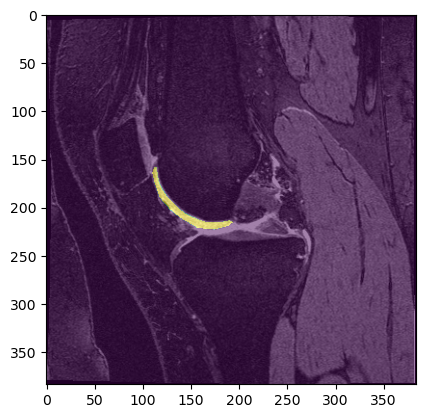

In [118]:
plt.imshow(data[0][0].numpy(),vmin = 0, vmax = 0.005, cmap = 'gray')
plt.imshow(data[0][1].numpy(),alpha = 0.5)

In [5]:
demo_dataloader = DataLoader(data, batch_size=8, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

img_embed.shape=torch.Size([8, 256, 64, 64]), gt2D.shape=torch.Size([8, 1, 256, 256]), bboxes.shape=torch.Size([8, 4])


In [6]:

sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.AdamW(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [7]:
device = 'cuda'
#%% train
num_epochs = 120
losses = []
best_loss = 1e10
# train_dataset = NpzDataset(npz_tr_path)
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(demo_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
#             print(sparse_embeddings.shape)
#             print(dense_embeddings.shape)
#             print(sam_model.prompt_encoder.get_dense_pe().shape)
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(),  'sam_model_latest.pth')
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(),  'sam_model_best.pth')

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 0, Loss: 0.6060370590005603


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 1, Loss: 0.5912110060453415


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 2, Loss: 0.6140152769429343


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 3, Loss: 0.6017006146056312


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 4, Loss: 0.5870681745665414


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 5, Loss: 0.5887325427361897


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 6, Loss: 0.608605927654675


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 7, Loss: 0.6111557313374111


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 8, Loss: 0.6113589874335698


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 9, Loss: 0.6051047763654164


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 10, Loss: 0.6137220242193767


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 11, Loss: 0.5963212634835925


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 12, Loss: 0.6063398803983416


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 13, Loss: 0.5939958265849522


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 14, Loss: 0.6002639702388218


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH: 15, Loss: 0.6067184209823608


  0%|          | 0/15 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = 'data/MedSAMDemo_2D/test/images'
ts_gt_path = 'data/MedSAMDemo_2D/test/labels'
test_names = sorted(os.listdir(ts_img_path))

# random select a test case
img_idx = np.random.randint(len(test_names))
image_data = io.imread(join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

In [17]:
class knee_val_60(Dataset):
    def __init__(self, paths, transform=None, target_transform=None):
        self.img_dir = paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        length = len(glob(self.img_dir[0] + "/*"))
        return length
    

    def __getitem__(self, idx):
        #There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
        fname_img = sorted(glob(self.img_dir[0] + "/*"))[idx]        
        #but there are multiple mask images in each mask path
        fname_seg = sorted(glob(self.img_dir[1] + "/*"))[idx]             
        #the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
        # img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        # img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        with h5py.File(fname_img,'r') as hf:
            img = np.array(hf['data'])
        # img = img/255.0
        img = np.moveaxis(img, -1, 0)
        
        if self.transform:
            img = torch.FloatTensor(img)
            state = torch.get_rng_state()
            img = self.transform(img)
            torch.set_rng_state(state)

            # img =img
        else:    
            img = torch.FloatTensor(img)
            image = F.interpolate(img.unsqueeze(0), (256, 256))
            image_data = np.uint8(np.repeat(image[0][60][:,:,None], 3, axis=-1))
       
        #Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background/ a  _different_ nuclei
        # masks  = imread(mask_imgs)/255.0
        with h5py.File(fname_seg,'r') as hf:
            seg = np.array(hf['data'])
    
        if self.target_transform:
            masks = torch.FloatTensor(seg)
            
            masks = masks.unsqueeze(0)
            masks = self.target_transform(seg)
           
        else:
            # final_mask = np.zeros(masks.shape)
            # final_mask = np.logical_or(final_mask, masks)
            seg = seg[...,0]
            seg = np.moveaxis(seg, -1, 0)
            masks = torch.Tensor(seg)
            label = F.interpolate(masks.to(torch.float).unsqueeze(0), (256, 256))
            ground_truth_mask = np.array(label[0][60])
            # get bounding box prompt
            prompt = get_bounding_box(ground_truth_mask)
            # masks =  F.one_hot(masks.to(torch.int64), 2).permute(2,0,1).contiguous()

        
        
        #Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
        # img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0) #First we convert to PyTorch tensors
        # #The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
        # image = F.interpolate(img.unsqueeze(0), (584, 584))
        # label = F.interpolate(masks.to(torch.float).unsqueeze(0), (584, 584))
        # Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". This will return a tuple of: (3, 256, 256), (1, 256, 256)
        return image_data, masks[60].unsqueeze(0), np.array(prompt)

In [68]:
class knee_val_60_ori(Dataset):
    def __init__(self, paths, transform=None, target_transform=None):
        self.img_dir = paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        length = len(glob(self.img_dir[0] + "/*"))
        return length
    

    def __getitem__(self, idx):
        #There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
        fname_img = sorted(glob(self.img_dir[0] + "/*"))[idx]        
        #but there are multiple mask images in each mask path
        fname_seg = sorted(glob(self.img_dir[1] + "/*"))[idx]             
        #the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
        # img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        # img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        with h5py.File(fname_img,'r') as hf:
            img = np.array(hf['data'])
        # img = img/255.0
        img = np.moveaxis(img, -1, 0)
        
        if self.transform:
            img = torch.FloatTensor(img)
            state = torch.get_rng_state()
            img = self.transform(img)
            torch.set_rng_state(state)

            # img =img
        else:    
            img = torch.FloatTensor(img)
       
        #Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background/ a  _different_ nuclei
        # masks  = imread(mask_imgs)/255.0
        with h5py.File(fname_seg,'r') as hf:
            seg = np.array(hf['data'])
    
        if self.target_transform:
            masks = torch.FloatTensor(seg)
            
            masks = masks.unsqueeze(0)
            masks = self.target_transform(seg)
           
        else:
            # final_mask = np.zeros(masks.shape)
            # final_mask = np.logical_or(final_mask, masks)
            seg = seg[...,0]
            seg = np.moveaxis(seg, -1, 0)
            masks = torch.Tensor(seg)
            # masks =  F.one_hot(masks.to(torch.int64), 2).permute(2,0,1).contiguous()

        
        
        #Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
        # img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0) #First we convert to PyTorch tensors
        # #The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
        image = F.interpolate(img.unsqueeze(0), (256,256))
        label = F.interpolate(masks.to(torch.float).unsqueeze(0), (256,256))
#         print(label.shape)
        # Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". This will return a tuple of: (3, 256, 256), (1, 256, 256)
        return image[0][60].unsqueeze(0), label[0][60].unsqueeze(0)

In [84]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
device = 'cuda'
idx =15
paths = sorted(glob("./valid/*"))
data = knee_val_60(paths)
image_data_pre = data[idx][0]
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'
sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
bbox_raw = data[idx][2]
H, W, _ = image_data_pre.shape
with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

bbox_raw=array([ 53,  91, 169, 168]) -> bbox=array([[212., 364., 676., 672.]])
(256, 256)


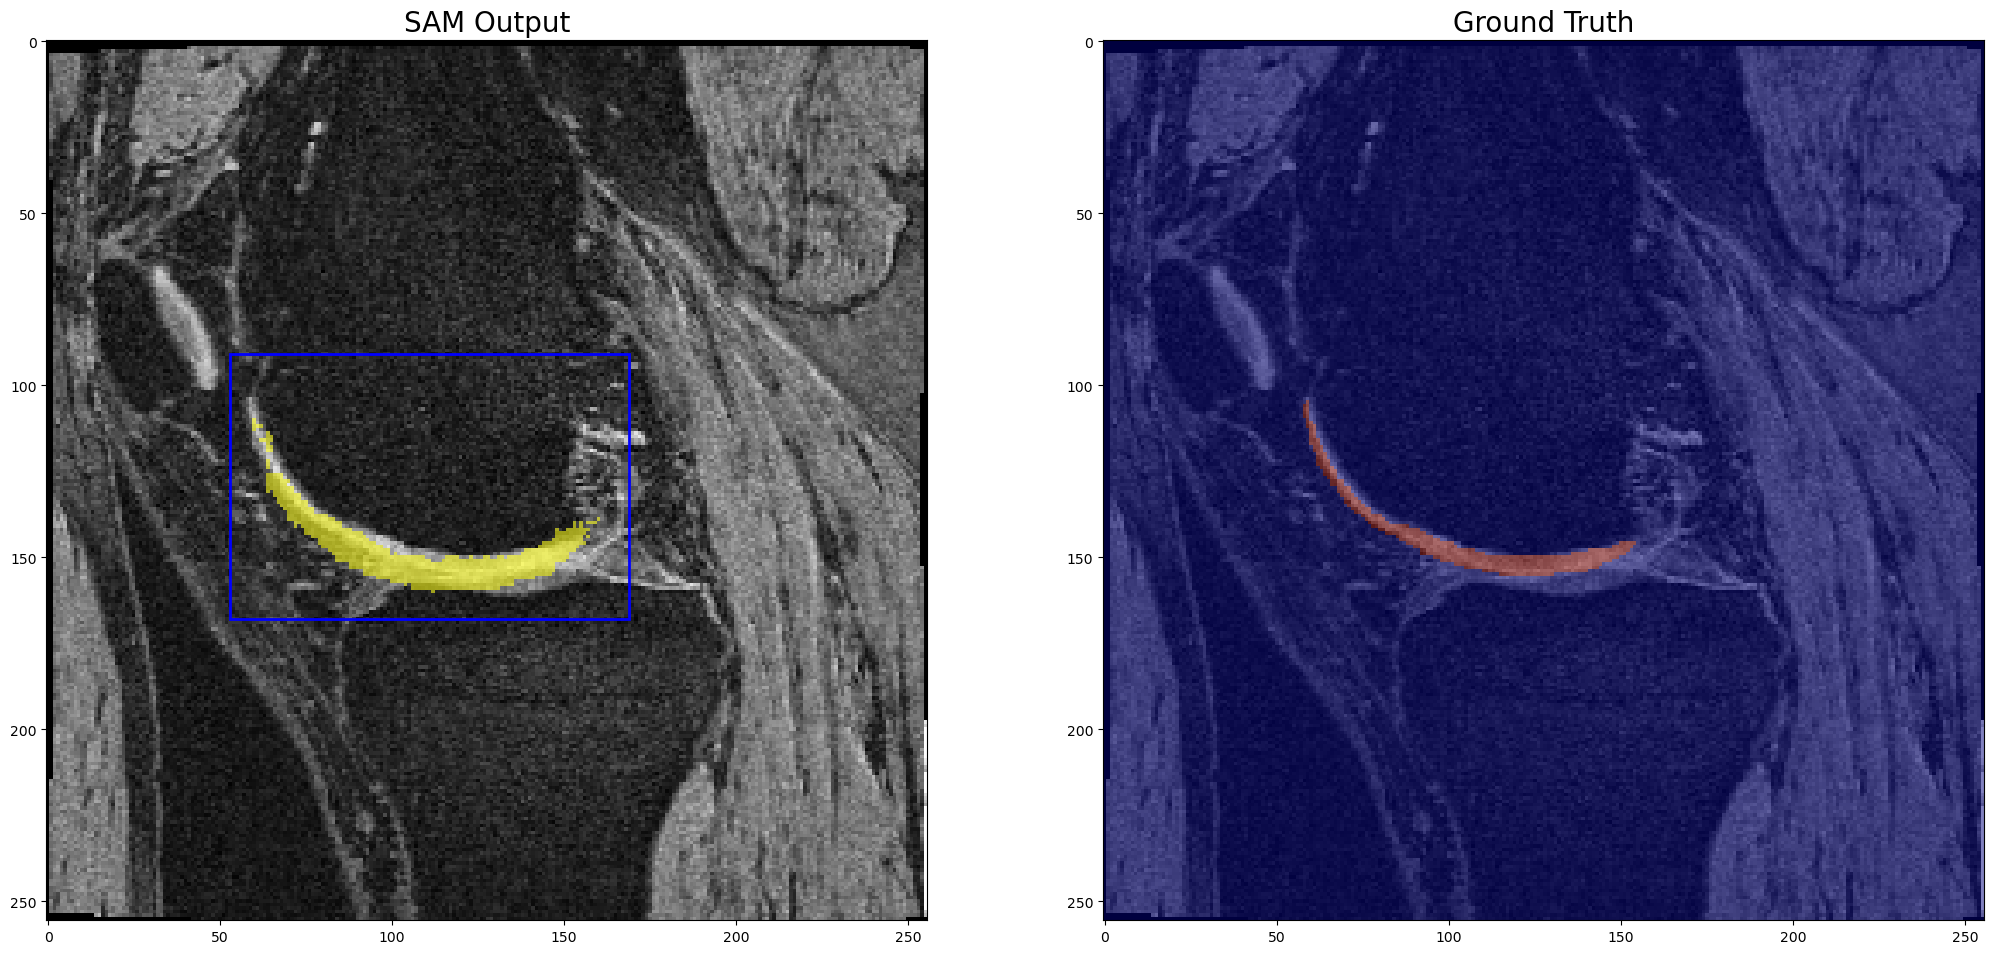

In [85]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 2, figsize=(25, 25))
# axs[0].imshow(image_data_pre, vmin = 0, vmax = 0.005,cmap='gray')
# show_mask(gt_data>0, axs[0])
# # show_box(box_np[img_id], axs[0])
# # axs[0].set_title('Mask with Tuned Model', fontsize=20)
# axs[0].axis('off')
paths = sorted(glob("./valid/*"))
data_ori = knee_val_60_ori(paths)  
image_data = data_ori[idx][0]
# print(image_data.shape)
axs[0].imshow(image_data.permute(1,2,0).numpy(),vmin = 0, vmax = 0.005, cmap = 'gray')
show_mask(medsam_seg, axs[0])
axs[0].set_title("SAM Output", fontsize=20)
show_box(bbox_raw, axs[0])

axs[1].imshow(image_data.permute(1,2,0).numpy(),vmin = 0, vmax = 0.005, cmap = 'gray')
axs[1].imshow(data_ori[idx][1].permute(1,2,0).numpy(), cmap='jet',alpha = 0.5) #Second is ground truth
axs[1].set_title('Ground Truth', fontsize=20)

plt.savefig('SAM Test.png', bbox_inches='tight')

# add text to image to show dice score
# axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')

# axs[0].axis('off')

In [ ]:
%run gui.py

Loading MedSAM model, a sec.
Done, took 9.842910549137741
